# Praca domowa nr 4 - testy metod

### Wojciech Celej

In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import *
from sklearn.metrics import *
import spectral
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (24,12)
plt.style.use("seaborn-whitegrid")
sns.set_context("notebook", font_scale=1.2)

In [3]:
dataset_directory = "pd4-zbiory-benchmarkowe"
data_suffix = ".data.gz"
label_suffix = ".labels0.gz"
myOwnDirectory = "myOwn"

---

## 1. Załadowanie zbiorów

In [4]:
benchmark_set = {}
path_to_dataset = os.path.join(dataset_directory, myOwnDirectory)
for file in os.listdir(path_to_dataset):
    if file.endswith(data_suffix):
        data = np.loadtxt(os.path.join(path_to_dataset, file), ndmin=2)
        data_set_name = file.split(".")[0]
        label_file_name = data_set_name + label_suffix
        label = np.loadtxt(os.path.join(path_to_dataset, label_file_name), dtype=np.int)
        d = {"x": data[:, 0], "y": data[:, 1], "label": label}
        df = pd.DataFrame(data=d)            
        benchmark_set[data_set_name] = df

---

## 2. Generacja wyników porównania, porównanie algorytmów na podstawie rysunków etykiet zbiorów w ukł. wsp.

Własna implementacja algorytmu spektralnego porównana zostanie z algorytmem *k-średnich* oraz implementacją *SpectralClustering* z pakietu `sklearn.cluster`. Liczba m sąsiadów wynosi 10, tyle samo ile wartość domyślna dla implementacji w `sklearn`.

In [5]:
column_names = ("benchmark_set", "algorithm", "FM", "AM", "AR")
results = pd.DataFrame(columns = column_names)

In [6]:
def append_row(df: pd.DataFrame, row):
    """
    df - DataFrame to which append
    row - tuple or list containing row values - must be in proper order
    return: new DataFrame object
    """
    if len(df.columns) != len(row):
        raise ValueError
    a = dict()
    for i in range(len(row)):
        a[df.columns[i]] = row[i]
    new_df = df.append(a, ignore_index=True)
    return new_df

def clustering_perf_evaluation(labels_true, labels_pred):
    fm = fowlkes_mallows_score(labels_true, labels_pred)
    am = adjusted_mutual_info_score(labels_true, labels_pred, average_method="arithmetic")
    ar = adjusted_rand_score(labels_true, labels_pred)
    assert np.all(labels_pred>=0)
    return fm, am, ar

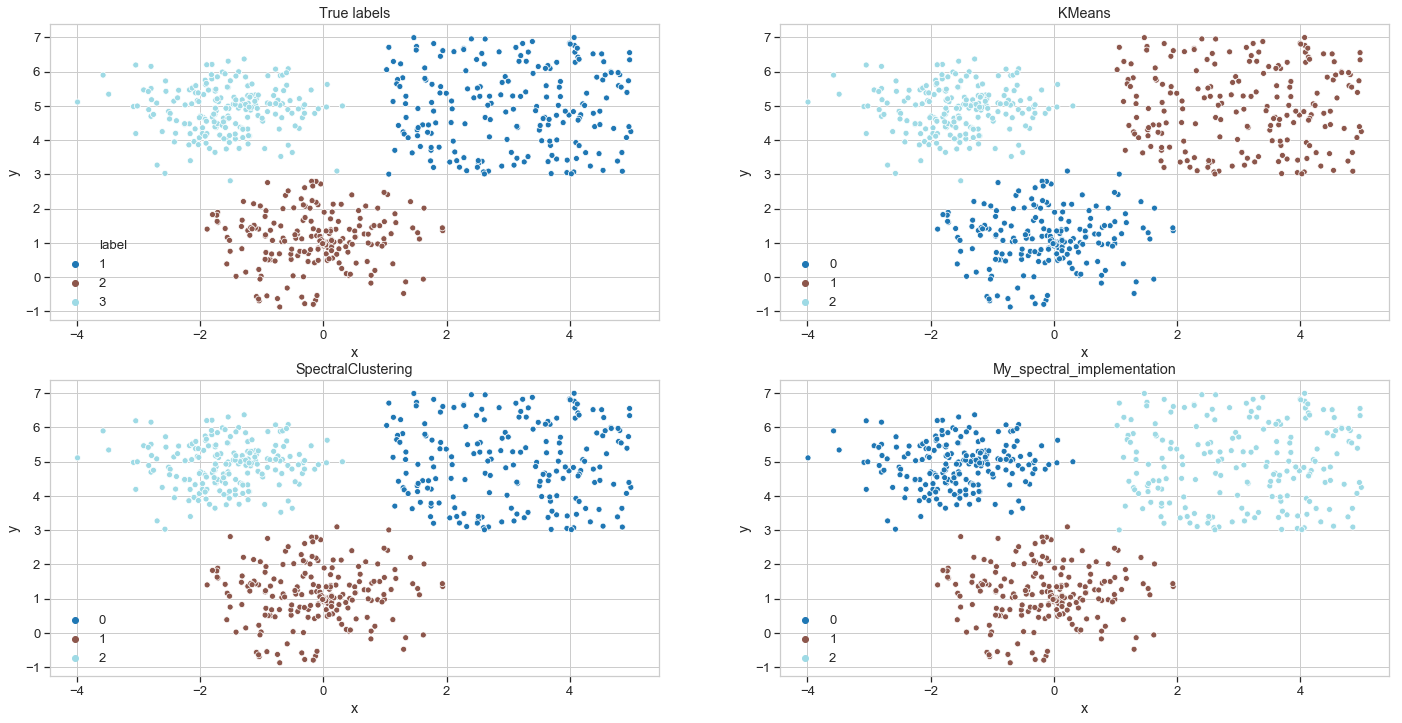

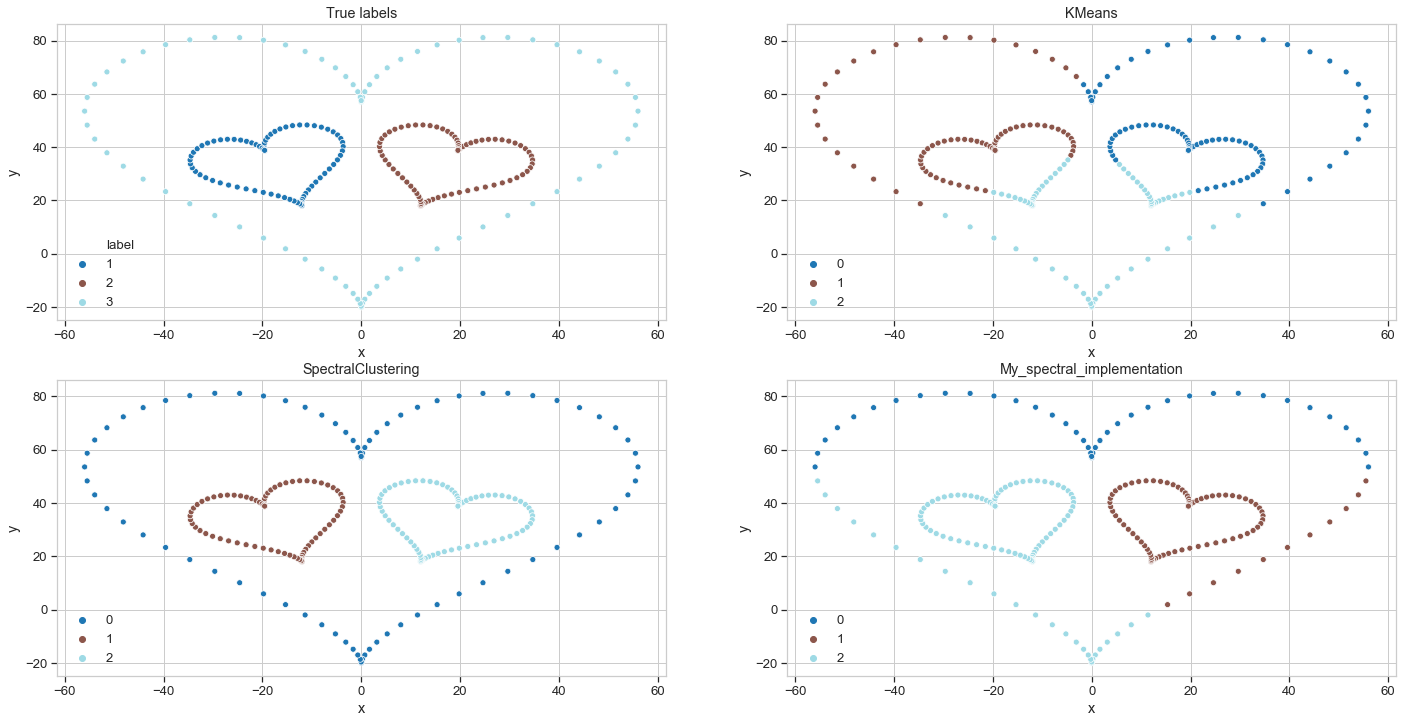

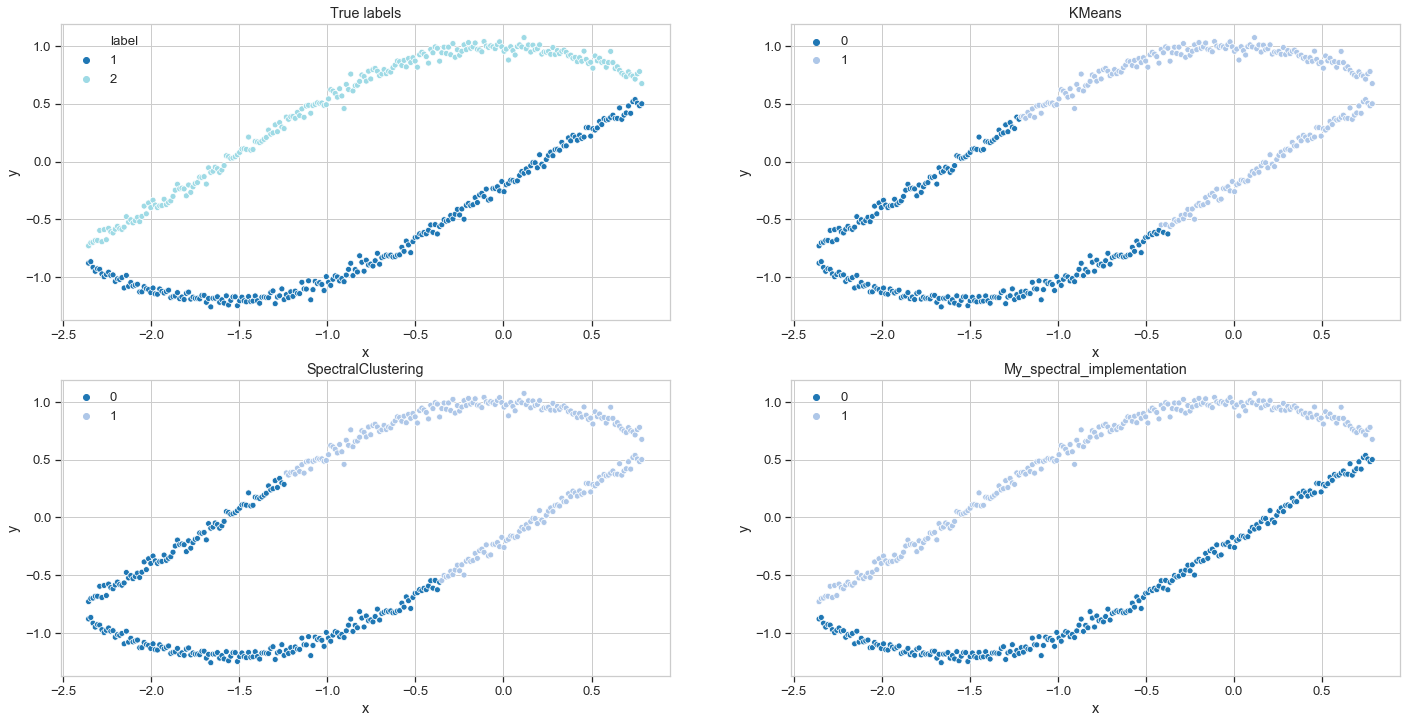

In [7]:
for key, value in benchmark_set.items():
    d = value
    X = d.loc[:, ["x", "y"]].values
    numOfClusters = d.loc[:, "label"].unique().shape[0]
    labels_true = d.loc[:, "label"].values
    
    ax1 = plt.subplot(221)
    ax1 = sns.scatterplot(data=d, x=d.columns[0], y=d.columns[1], hue=d.columns[2], legend="full", palette="tab20")
    ax1.set_title("True labels")
    
    labels_pred1 = KMeans(n_clusters=numOfClusters).fit_predict(X)
    ax2 = plt.subplot(222)
    ax2 = sns.scatterplot(data=d, x=d.columns[0], y=d.columns[1], hue=labels_pred1, legend="full", palette="tab20")
    ax2.set_title("KMeans")
    fm, am, ar = clustering_perf_evaluation(labels_true, labels_pred1)
    results = append_row(results, (key, "KMeans", fm, am, ar))
    
    labels_pred2 = SpectralClustering(n_clusters=numOfClusters).fit_predict(X) 
    ax3 = plt.subplot(223)
    ax3 = sns.scatterplot(data=d, x=d.columns[0], y=d.columns[1], hue=labels_pred2, legend="full", palette="tab20")
    ax3.set_title("SpectralClustering")
    fm, am, ar = clustering_perf_evaluation(labels_true, labels_pred2)
    results = append_row(results, (key, "SpectralClustering", fm, am, ar))
    
    labels_pred3 = spectral.spectral_clustering(X, numOfClusters, 10)
    ax4 = plt.subplot(224)
    ax4 = sns.scatterplot(data=d, x=d.columns[0], y=d.columns[1], hue=labels_pred3, legend="full", palette="tab20")
    ax4.set_title("My_spectral_implementation")
    fm, am, ar = clustering_perf_evaluation(labels_true, labels_pred3)
    results = append_row(results, (key, "My_Spectral_Impl", fm, am, ar))
    plt.show()

---

## 3. Ranking algorytmów wg. poszczególnych indeksów

Indeksy dla których policzono wartości:
* indeks Fowlkesa-Mallowsa (FM): `sklearn.metrics.fowlkes_mallows_score()`
* indeks AM: `sklearn.metrics.adjusted_mutual_info_score()`
* skorygowany indeksu Randa (AR): `sklearn.metrics.adjusted_rand_score()`  

Wartości indeksów zostały poniżej podane dla każdego zbioru. Algorytmy testowano dla domyślnych parametrów. 

In [8]:
results

,benchmark_set,algorithm,FM,AM,AR
0,3distr,KMeans,0.993308,0.980828,0.989979
1,3distr,SpectralClustering,0.989975,0.973349,0.984988
2,3distr,My_Spectral_Impl,0.993334,0.982941,0.990017
3,3hearts,KMeans,0.483235,0.283013,0.227338
4,3hearts,SpectralClustering,1.000000,1.000000,1.000000
5,3hearts,My_Spectral_Impl,0.752167,0.656534,0.616376
6,sinAndCos,KMeans,0.531962,0.047960,0.065728
7,sinAndCos,SpectralClustering,0.537364,0.055956,0.076550
8,sinAndCos,My_Spectral_Impl,1.000000,1.000000,1.000000


Wykresy poniżej przedstawiają porównanie algorytmów wg. w/w indeksów uśrednione po zbiorach.

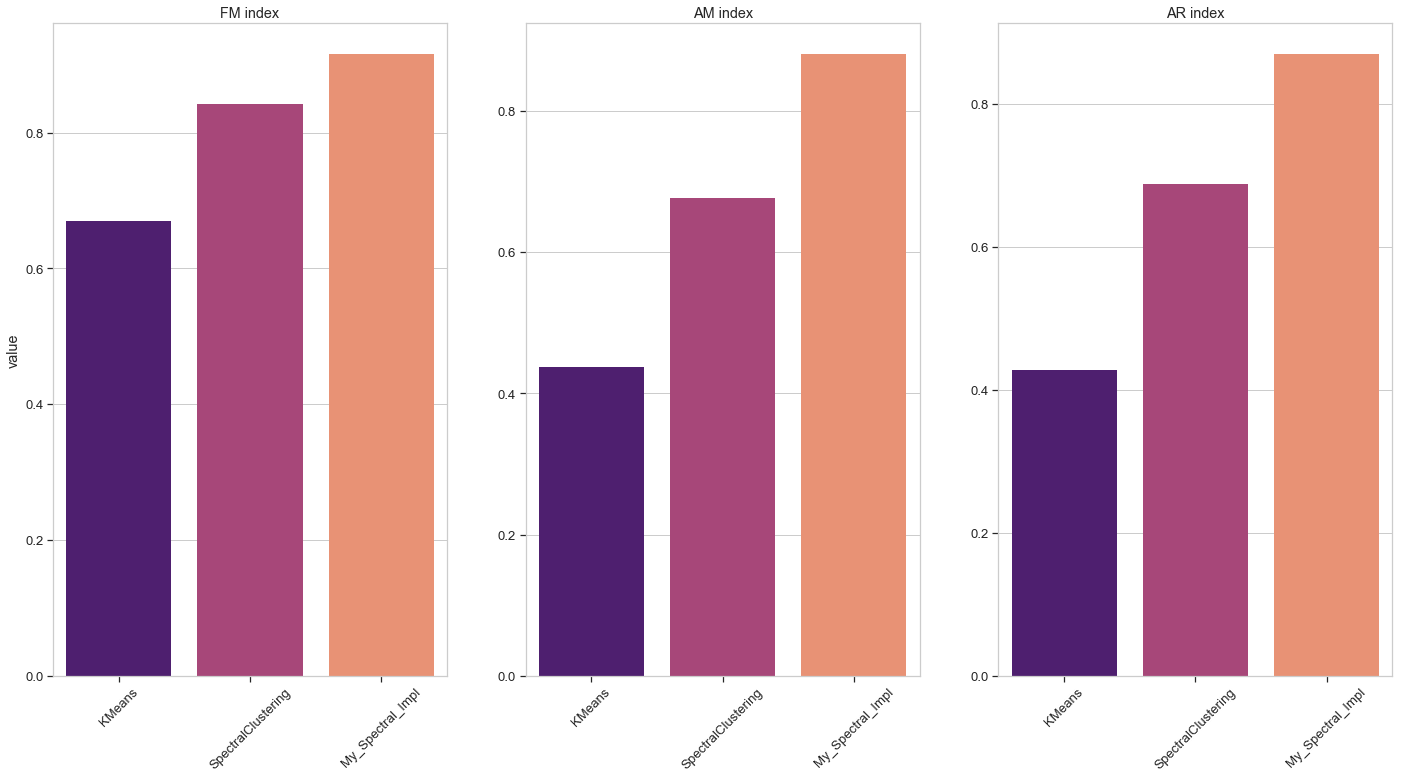

In [9]:
q1 = results.groupby("algorithm").mean().reset_index()

plt.subplot(131)
sns.barplot(data=q1.sort_values("FM"), x="algorithm", y="FM", palette="magma")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title("FM index")
plt.xlabel("")
plt.ylabel("value")

plt.subplot(132)
sns.barplot(data=q1.sort_values("AM"), x="algorithm", y="AM", palette="magma")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title("AM index")
plt.xlabel("")
plt.ylabel("")

plt.subplot(133)
sns.barplot(data=q1.sort_values("AR"), x="algorithm", y="AR", palette="magma")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel("")
plt.ylabel("")
plt.title("AR index")

plt.show()

---

## 4. Mapy ciepła zbiór - algorytm

In [10]:
bench_sets = list(results.loc[:, "benchmark_set"].drop_duplicates())
algorithms = list(results.loc[:, "algorithm"].drop_duplicates())
indexes = list(results.columns[2:])

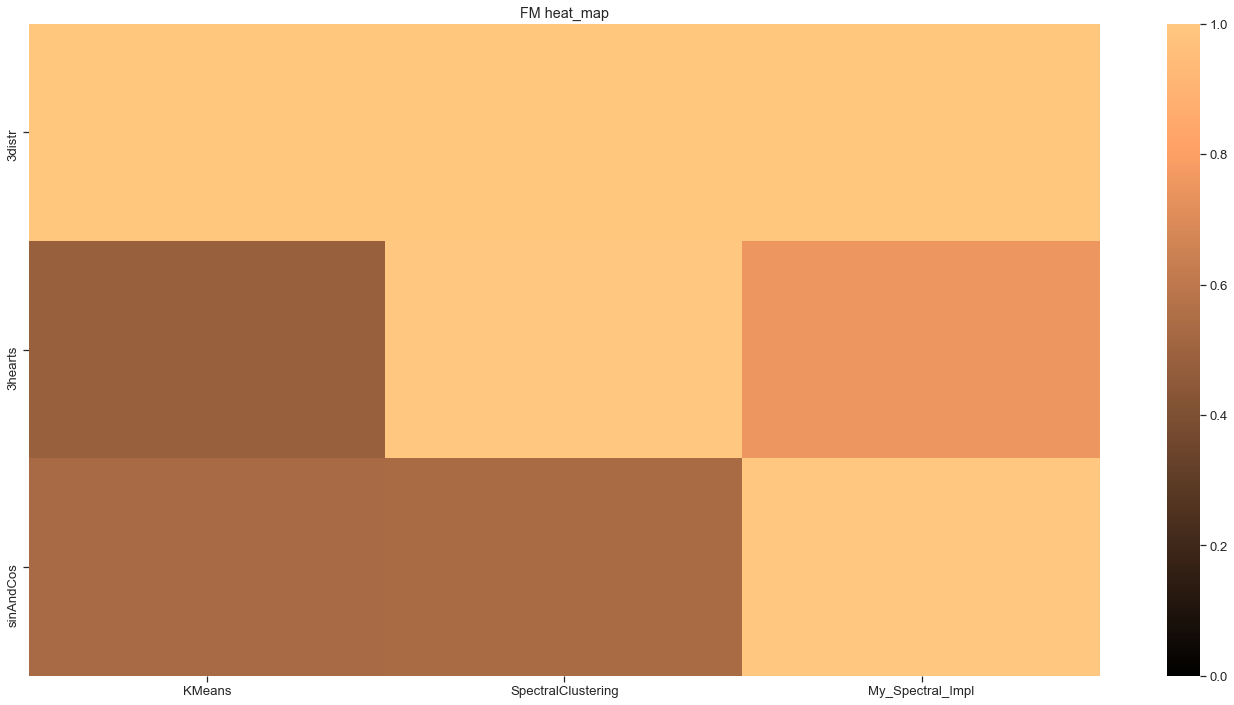

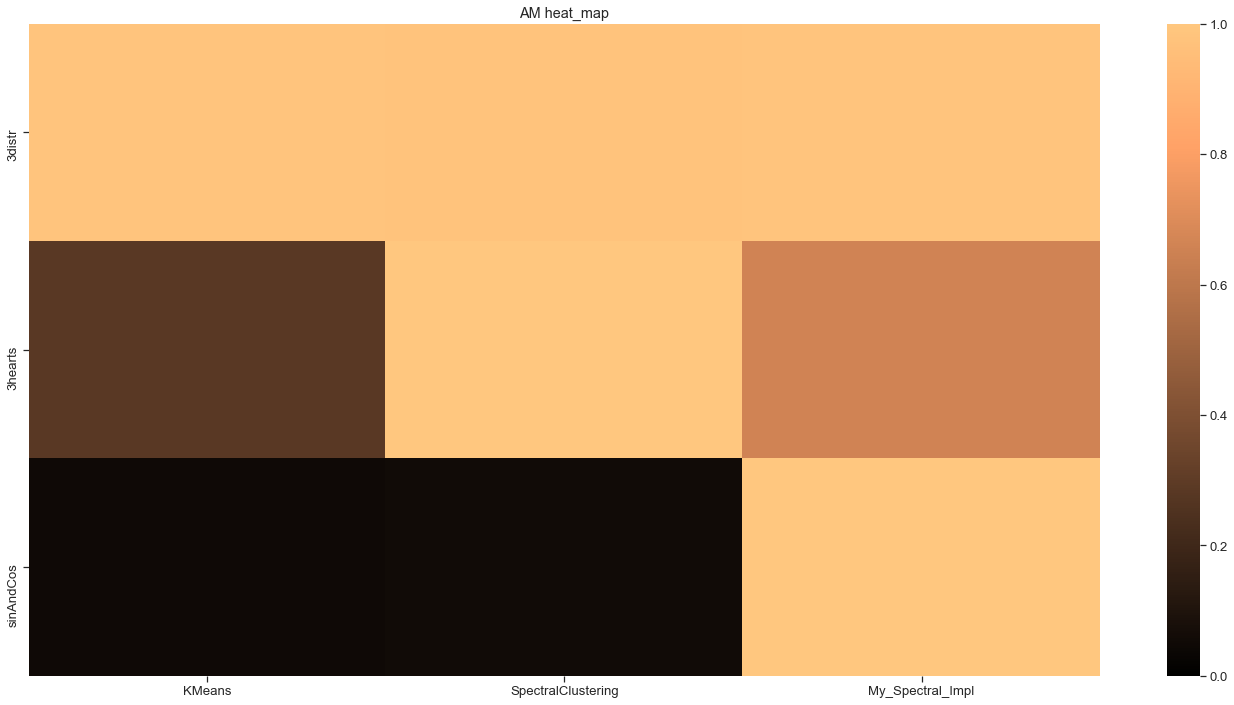

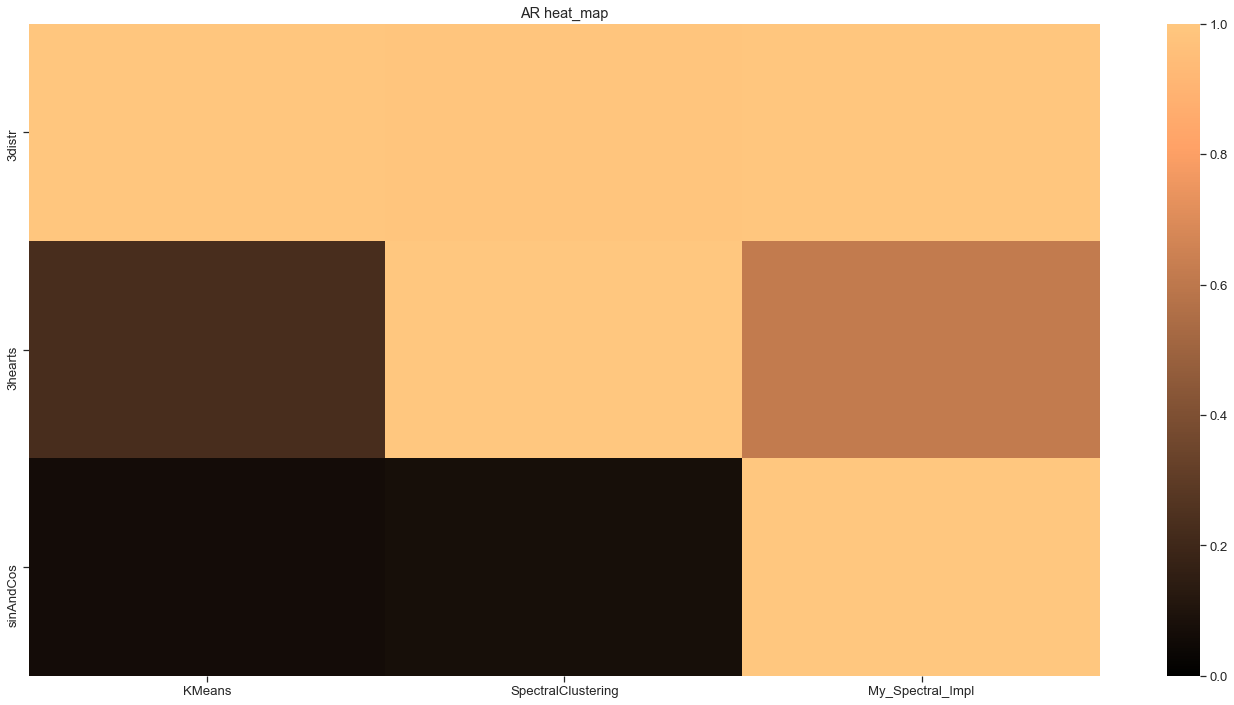

In [11]:
for index in indexes:
    fm_df = pd.DataFrame(index=bench_sets, columns=algorithms, dtype=np.float)
    for bench_set in bench_sets:
        for algorithm in algorithms:
            fm_df.loc[bench_set, algorithm] = float(results.loc[results.algorithm==algorithm].loc[results.benchmark_set==bench_set].loc[:, index])
    sns.heatmap(data=fm_df, vmin=0, vmax=1, cmap="copper")
    plt.title(index + " heat_map")
    plt.show()

## 5. Porównanie implementacji algorytmu spektralnego dla różnych parametrów `M`

Paramter `M` to liczba najbliższych sąsiadów. Na podstawie tej liczby jest budowana odpowiednia macierz sąsiedztwa.

In [12]:
column_names2 = ("benchmark_set", "n_neighbors", "FM", "AM", "AR")
results2 = pd.DataFrame(columns = column_names2)

In [13]:
n_neighbors = range(2, 17, 2)

In [14]:
for n_neigh in n_neighbors:
    for set_name, set_data in benchmark_set.items():
        d = set_data
        X = d.loc[:, ["x", "y"]].values
        numOfClusters = d.loc[:, "label"].unique().shape[0]
        labels_true = d.loc[:, "label"].values
        labels_pred = spectral.spectral_clustering(X, numOfClusters, n_neigh)
        fm, am, ar = clustering_perf_evaluation(labels_true, labels_pred)
        row_values = (set_name, n_neigh, fm, am, ar)
        results2 = append_row(results2, row_values)

Wartości indeksów zostały poniżej podane dla każdego zbioru w zależności o parametru `M`.

In [15]:
results2

,benchmark_set,n_neighbors,FM,AM,AR
0,3distr,2,0.456406,0.149848,0.093376
1,3hearts,2,0.648660,0.559919,0.446668
2,sinAndCos,2,0.646829,0.196113,0.077510
3,3distr,4,0.989975,0.973349,0.984988
4,3hearts,4,0.765864,0.676040,0.639304
5,sinAndCos,4,0.723070,0.453952,0.408568
6,3distr,6,0.993334,0.982941,0.990017
7,3hearts,6,0.760802,0.668171,0.631009
8,sinAndCos,6,0.788766,0.563112,0.564685
9,3distr,8,0.993334,0.982941,0.990017


Wykresy poniżej przedstawiają porównanie dla pewnego zakresu parametru `M` w uśrednione po zbiorach.

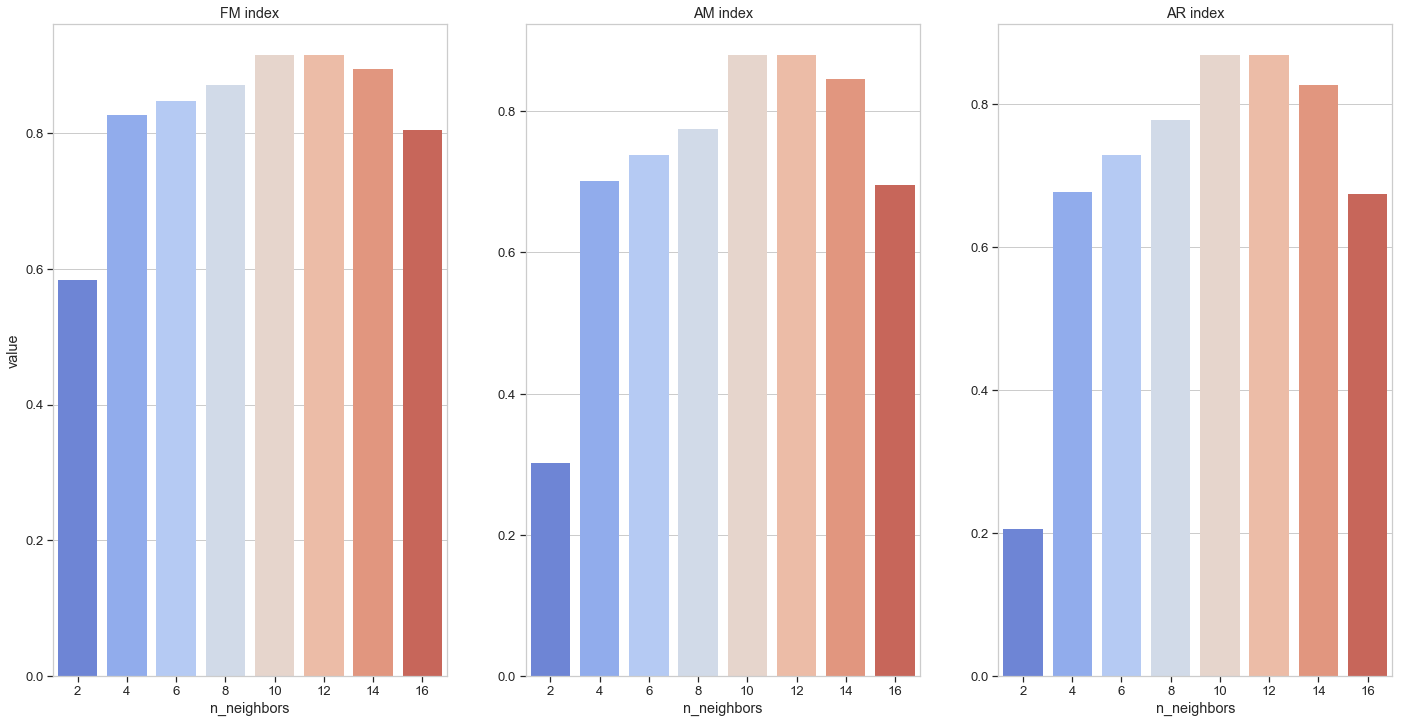

In [16]:
q2 = results2.groupby("n_neighbors").mean().reset_index()

plt.subplot(131)
sns.barplot(data=q2, x="n_neighbors", y="FM", palette="coolwarm")
locs, labels = plt.xticks()
plt.title("FM index")
plt.ylabel("value")

plt.subplot(132)
sns.barplot(data=q2, x="n_neighbors", y="AM", palette="coolwarm")
locs, labels = plt.xticks()
plt.title("AM index")
plt.ylabel("")

plt.subplot(133)
sns.barplot(data=q2, x="n_neighbors", y="AR", palette="coolwarm")
locs, labels = plt.xticks()
plt.title("AR index")
plt.ylabel("")

plt.show()